In [1]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import time
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import spacy
from anchor import anchor_text
import pickle
from myUtils import *
import transformerUtils.models as models
import transformerUtils.training as training
import transformerUtils.plot as plot
from transformerUtils.utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
review_parser = None
label_parser = None
ds_train = None
ds_valid = None
ds_test = None

review_parser, label_parser, ds_train, ds_valid, ds_test = counter_dataset()
counter_test, counter_test_labels = counter_test()

Number of tokens in training samples: 7557
Number of tokens in training labels: 2


## Forward Function For Getting Accuracy

In [6]:
model = load_model('gru' , 'transformerUtils/counter_gru.pt', review_parser)

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.7, 'lr': 0.0005, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(7557, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.7)
  (dropout_layer): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [4]:
# 1 = pad 2=sos 3 = eof 
def tokenize(text, max_len):
    sentence = review_parser.tokenize(str(text))
    input_tokens = [2] + [review_parser.vocab.stoi[word] for word in sentence] + [3] + [1]*(max_len-len(sentence))

    return input_tokens

In [5]:
def predict_sentences(sentences):
    half_length = len(sentences)//2
    if(half_length>100):
        return np.concatenate([predict_sentences(sentences[:half_length]), predict_sentences(sentences[half_length:])])
    max_len = max([len(sentence) for sentence in sentences])
    sentences = torch.tensor([tokenize(sentence, max_len) for sentence in sentences]).to(device)
    input_tokens = torch.transpose(sentences, 0, 1)
    output = model(input_tokens)
    return torch.argmax(output, dim=1).cpu().numpy()

# Anchor Part

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
explainer = anchor_text.AnchorText(nlp, ['negative', 'positive'], use_unk_distribution=False)

In [9]:
train, train_labels = [' '.join(example.text) for example in ds_train], [example.label for example in ds_train]
test, test_labels = [' '.join(example.text) for example in ds_train], [example.label for example in ds_train]

In [10]:
anchor_examples = [example for example in train if len(example) < 70 and len(example)>20]

In [21]:
pickle.dump( test, open( "results/transformer_test.pickle", "wb" ))
pickle.dump( test_labels, open( "results/transformer_test_labels.pickle", "wb" ))

In [ ]:
my_utils = TextUtils(anchor_examples, counter_test, explainer, predict_sentences, "results/transformer_exps.pickle")
explanations = my_utils.compute_explanations(list(range(len(anchor_examples))))

In [ ]:
pickle.dump( explanations, open( "results/transformer_exps_list.pickle", "wb" ))

In [5]:
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path
def train_model(model_name, device, output_directory = 'results'):
    NUM_EPOCHS = 100
    if model_name == 'gru':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.VanillaGRU(review_parser.vocab, hp['embedding_dim'], hp['hidden_dim'], hp['num_layers'], hp['output_classes'], hp['dropout']).to(device)
    elif model_name == 'attention':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.MultiHeadAttentionNet(input_vocabulary=review_parser.vocab, embed_dim=hp['embedding_dim'], num_heads=hp['num_heads'], 
                                           dropout=hp['dropout'], two_attention_layers=hp['two_atten_layers'], output_classes=hp['output_classes']).to(device)
    print(model)
    dl_train, dl_valid, dl_test = torchtext.legacy.data.BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=hp['batch_size'], sort = False, shuffle=True, device=device)

    optimizer = optim.Adam(model.parameters(), lr=hp['lr'])
    loss_fn = nn.NLLLoss()
    
    trainer = training.SentimentTrainer(model, loss_fn, optimizer, device)
    checkpoint_filename = str(output_directory) +  '/' + model_name
    print(f'Saving checkpoint with prefix: {checkpoint_filename}')
    fit_res = trainer.fit(dl_train, dl_valid, NUM_EPOCHS, early_stopping = hp['early_stopping'], checkpoints = checkpoint_filename, params = hp)

    fig, axes = plot.plot_fit(fit_res)
    fig.savefig(output_directory + '/' + str(model_name + '.png'))
    saved_state = torch.load(checkpoint_filename + '.pt', map_location=device)
    model.load_state_dict(saved_state["model_state"])
    loaded_hp = saved_state["parameters"]
    print('----- Loaded params ------')
    print(loaded_hp)
    all_dataloaders = [dl_train, dl_valid, dl_test]
    type_dls = ['train', 'valid', 'test']
    accuracies = []
    for dl, type_dl in zip(all_dataloaders, type_dls):
        y_real, y_pred, accuracy = forward_dl(model, dl, device, type_dl)
        df = compute_confusion_matrix(y_real, y_pred, model_name, type_dl)
        accuracies.append(accuracy)
        display(df)
    numpy_accuracy = np.array(accuracies)
    df = pd.DataFrame(numpy_accuracy, index = type_dls, dtype=float)
    df.to_csv(output_directory + '/' + str('accuracies_' + model_name + '.csv')) 

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.7, 'lr': 0.0005, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(3307, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.7)
  (dropout_layer): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)
Saving checkpoint with prefix: results/gru
--- EPOCH 1/100 ---
test_batch (Avg. Loss 0.693, Accuracy 50.1): 100%|██████████| 32/32 [00:00<00:00, 258.41it/s]
*** Saved checkpoint results/gru.pt at epoch 1
--- EPOCH 2/100 ---
test_batch (Avg. Loss 0.694, Accuracy 47.6): 100%|██████████| 32/32 [00:00<00:00, 257.95it/s]
--- EPOCH 3/100 ---
test_batch (Avg. Loss 0.695, Accuracy 47.6): 100%|██████████| 32/32 [00:00<00:00, 257.66it/s]
--- EPOCH 4/100 ---
test_batch (Avg. Loss 0.642, Accuracy 62.9): 100%|██████████| 32/32 [00:00<00:00, 258.25it/s]
*** Saved checkpoint results/gru.pt at epoch 4
---

NameError: name 'compute_confusion_matrix' is not defined

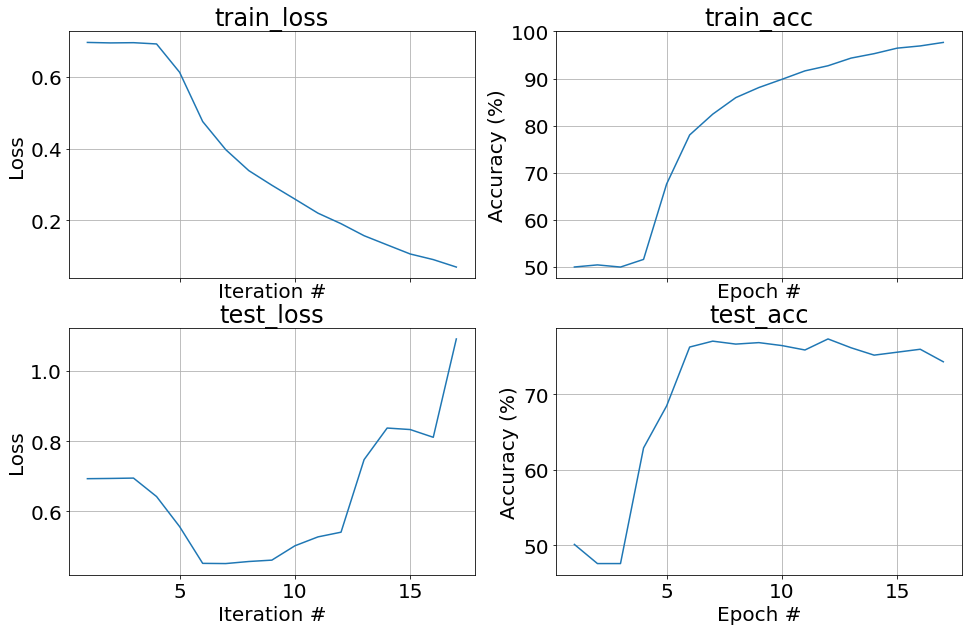

In [7]:
SEED = 84
torch.manual_seed(SEED)
#train_model('gru', device)

In [ ]:
SEED = 84
torch.manual_seed(SEED)
#train_model('attention', device)

# Loading Results

In [8]:
explanations= []
#xps_file  = open( "results/transformer_exps.pickle", "rb" )
explanations  = pickle.load(open( "results/counter_gru_exps_list.pickle", "rb" ))
anchor_examples = pickle.load(open( "results/transformer_anchor_examples.pickle", "rb" ))

In [ ]:
num_exps = 2000
for _ in range(num_exps):
    explanations.append(pickle.load(exps_file))
exps_file.close()

In [9]:
myUtils =  TextUtils(counter_test, counter_test, None, None, "results/transformer_exps.pickle")
explanations = myUtils.remove_duplicates(explanations)

In [12]:
explanations = [ExtendedExplanation(exp, anchor_examples, counter_test, counter_test_labels, predict_sentences, explainer) for exp in explanations if len(exp.fit_examples) > 1]

In [13]:
pickle.dump( explanations, open( "results/counter_gru_extended_exps.pickle", "wb" ))

In [11]:
explanations = pickle.load(open( "results/counter_gru_extended_exps.pickle", "rb" ))

In [14]:
explanations = [exp for exp in explanations if len(exp.fit_examples) > 10] 
explanations.sort(key=lambda exp: exp.test_precision)

In [15]:
predict_sentences(['bad', 'good', 'pointless'])

array([0, 1, 0])

In [42]:
pickle.dump( anchor_examples, open( "results/transformer_anchor_examples.pickle", "wb" ))

In [48]:
predict_sentences(counter_test[explanations[198].fit_examples])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [54]:
predict_sentences([anchor_examples[536]])

array([0])

In [36]:
filtered = [exp for exp in explanations if len(' '.join(exp.names))>6]
best = filtered[-10:]
best.reverse()
for exp in best:
    print("------------------------")
    print(str(anchor_examples[exp.index]))
    exp_label =  predict_sentences([str(anchor_examples[exp.index])])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % exp.test_precision)
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = counter_test_labels[exp.fit_examples]
    real_percentage = np.mean(covered_labels == exp_label)
    print('Anchor test REAL precision: %.2f' % exp.real_precision)
   

------------------------
a film with a great premise but only a great premise .
Prediction: positive
Anchor: great AND film AND great AND a AND a AND . AND with AND a
Precision: 0.85
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.12
Anchor test REAL precision: 0.72
------------------------
  . . . an inviting piece of film .
Prediction: negative
Anchor: an AND piece AND film AND . AND of AND . AND .
Precision: 0.21
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.06
Anchor test REAL precision: 0.52
------------------------
this is a very fine movie -- go see it .
Prediction: positive
Anchor: -- AND go AND .
Precision: 0.94
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.04
Anchor test REAL precision: 0.53
------------------------
what i saw , i enjoyed .
Prediction: negative
Anchor: enjoyed AND i AND i AND .
Precision: 0.47
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.03
Anchor test REAL precision: 0.81
----

In [57]:
exps = explanations
exps = [exp for exp in exps if len(exp.fit_examples)>10]
#trained model has the opposite label
real_precisions = [exp.real_precision for exp in exps]
test_precisions = [exp.test_precision for exp in exps]

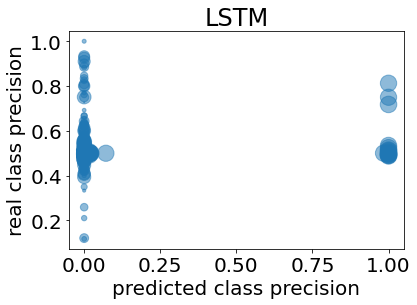

In [58]:
plt.scatter(test_precisions, real_precisions, s = range(len(exps)), alpha = 0.5)
plt.xlabel('predicted class precision')
plt.ylabel('real class precision')
plt.title('LSTM')
plt.savefig("results/transformer.png")

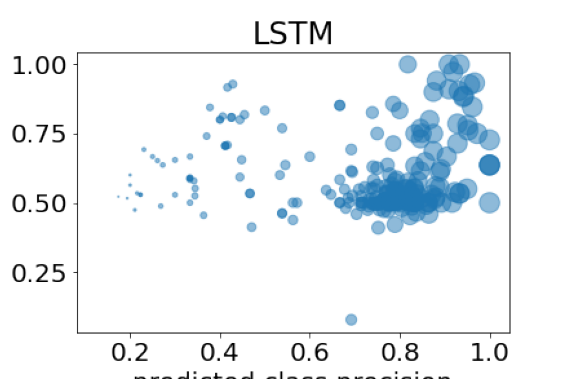

In [69]:
img = plt.imread("results/transformer.png")
plt.figure(figsize = (10,10))
plt.axis('off')
_ = plt.imshow(img)